In [ ]:
# ------------------------------------------------------------
# Gradient Descent Training Skeleton (PyTorch, Colab Ready)
# ------------------------------------------------------------
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import make_moons, make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [ ]:
# ------------------------------------------------------------
# 1. Configs (set binary=True for 2-class BCE, else CrossEntropy)
# ------------------------------------------------------------
binary = True     # True = 2-class BCE, False = multi-class CE
num_classes = 2 if binary else 3
lr = 1e-3
epochs = 50
batch_size = 64
patience = 5

In [ ]:
# ------------------------------------------------------------
# 2. Make synthetic dataset
# ------------------------------------------------------------
if binary:
    X, y = make_moons(n_samples=2000, noise=0.2, random_state=42)
else:
    X, y = make_classification(n_samples=2000, n_features=10,
                               n_classes=num_classes, n_informative=5,
                               random_state=42)

scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long if not binary else torch.float32)
X_val   = torch.tensor(X_val, dtype=torch.float32)
y_val   = torch.tensor(y_val, dtype=torch.long if not binary else torch.float32)

train_ds = torch.utils.data.TensorDataset(X_train, y_train)
val_ds   = torch.utils.data.TensorDataset(X_val, y_val)

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = torch.utils.data.DataLoader(val_ds, batch_size=batch_size)


In [ ]:
# ------------------------------------------------------------
# 3. Define a simple model
# ------------------------------------------------------------
class SimpleMLP(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 32),
            nn.ReLU(),
            nn.Linear(32, out_dim)
        )
    def forward(self, x):
        return self.net(x)

model = SimpleMLP(X_train.shape[1], 1 if binary else num_classes)

In [ ]:
# ------------------------------------------------------------
# 4. Define loss & optimizer
# ------------------------------------------------------------
if binary:
    criterion = nn.BCEWithLogitsLoss()   # expects raw logits
else:
    criterion = nn.CrossEntropyLoss()    # expects raw logits + int labels

optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=2)

In [ ]:
# ------------------------------------------------------------
# 5. Training loop with early stopping
# ------------------------------------------------------------
best_val_loss = float("inf")
patience_counter = 0
train_losses, val_losses = [], []

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        logits = model(xb)
        if binary:
            logits = logits.squeeze(1)          # shape [batch]
            loss = criterion(logits, yb)        # BCE expects float targets
        else:
            loss = criterion(logits, yb)        # CE expects int targets
        loss.backward()
        # Optional: gradient clipping
        # nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        total_loss += loss.item()
    avg_train = total_loss / len(train_loader)
    train_losses.append(avg_train)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            logits = model(xb)
            if binary:
                logits = logits.squeeze(1)
                loss = criterion(logits, yb)
            else:
                loss = criterion(logits, yb)
            val_loss += loss.item()
    avg_val = val_loss / len(val_loader)
    val_losses.append(avg_val)
    scheduler.step(avg_val)

    print(f"Epoch {epoch+1:02d}: train={avg_train:.4f}, val={avg_val:.4f}")

    # Early stopping
    if avg_val < best_val_loss:
        best_val_loss = avg_val
        patience_counter = 0
        torch.save(model.state_dict(), "best_model.pt")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

Epoch 01: train=0.7293, val=0.6820
Epoch 02: train=0.6599, val=0.6235
Epoch 03: train=0.6011, val=0.5715
Epoch 04: train=0.5476, val=0.5216
Epoch 05: train=0.4965, val=0.4754
Epoch 06: train=0.4494, val=0.4345
Epoch 07: train=0.4092, val=0.4000
Epoch 08: train=0.3760, val=0.3735
Epoch 09: train=0.3513, val=0.3529
Epoch 10: train=0.3323, val=0.3376
Epoch 11: train=0.3183, val=0.3259
Epoch 12: train=0.3075, val=0.3169
Epoch 13: train=0.2991, val=0.3098
Epoch 14: train=0.2926, val=0.3037
Epoch 15: train=0.2871, val=0.2991
Epoch 16: train=0.2829, val=0.2952
Epoch 17: train=0.2791, val=0.2920
Epoch 18: train=0.2760, val=0.2891
Epoch 19: train=0.2731, val=0.2865
Epoch 20: train=0.2707, val=0.2842
Epoch 21: train=0.2684, val=0.2821
Epoch 22: train=0.2661, val=0.2801
Epoch 23: train=0.2639, val=0.2782
Epoch 24: train=0.2618, val=0.2762
Epoch 25: train=0.2598, val=0.2743
Epoch 26: train=0.2578, val=0.2724
Epoch 27: train=0.2558, val=0.2705
Epoch 28: train=0.2538, val=0.2686
Epoch 29: train=0.25

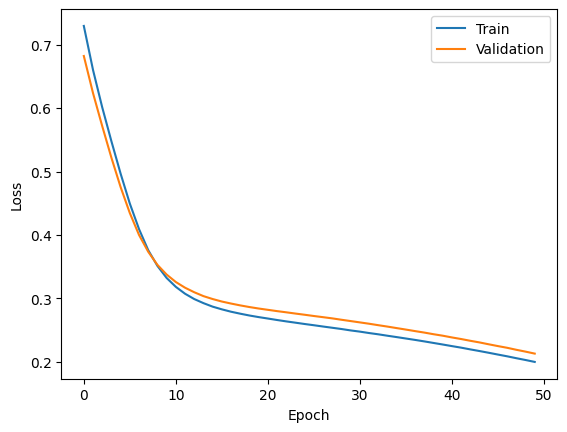

In [ ]:
# ------------------------------------------------------------
# 6. Plot training/validation loss
# ------------------------------------------------------------
plt.plot(train_losses, label="Train")
plt.plot(val_losses, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.3801 - loss: 1.1147 - val_accuracy: 0.5325 - val_loss: 0.9952 - learning_rate: 0.0010
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6195 - loss: 0.9316 - val_accuracy: 0.6300 - val_loss: 0.8847 - learning_rate: 0.0010
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6905 - loss: 0.8125 - val_accuracy: 0.6800 - val_loss: 0.8016 - learning_rate: 0.0010
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7199 - loss: 0.7245 - val_accuracy: 0.7150 - val_loss: 0.7395 - learning_rate: 0.0010
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7453 - loss: 0.6621 - val_accuracy: 0.7350 - val_loss: 0.6963 - learning_rate: 0.0010
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7837 - loss: 0.5707 - val_accuracy: 0.7500 - val_loss: 0.6561 - learning_rate: 0.0010
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8054 - loss: 0.5218 - val_accuracy: 0.7825 - v

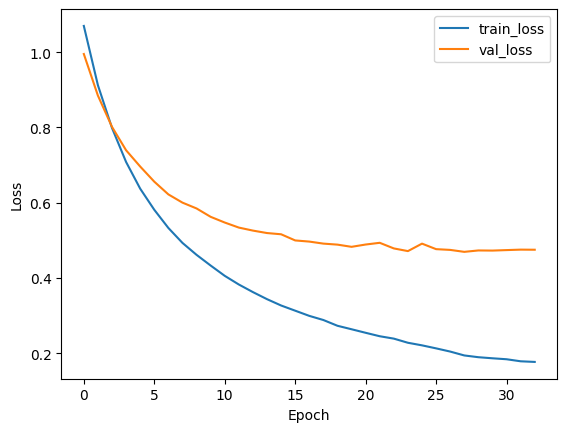

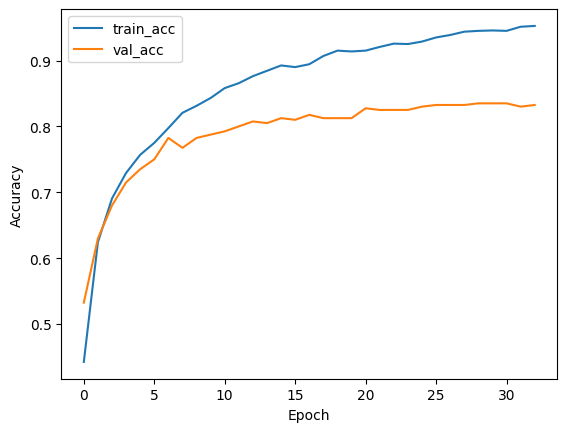

In [8]:
# ------------------------------------------------------------
# Full Colab-Ready Keras Training Script
# ------------------------------------------------------------
import tensorflow as tf
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 1. Generate synthetic multi-class dataset
X, y = make_classification(n_samples=2000, n_features=20, n_classes=3,
                           n_informative=10, random_state=42)

# scale features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# train/val split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# convert to TensorFlow datasets
train_ds = tf.data.Dataset.from_tensor_slices((X_train, tf.keras.utils.to_categorical(y_train, 3)))
train_ds = train_ds.shuffle(1024).batch(64)

val_ds = tf.data.Dataset.from_tensor_slices((X_val, tf.keras.utils.to_categorical(y_val, 3)))
val_ds = val_ds.batch(64)

# 2. Define a simple model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation="relu", input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(3)  # raw logits, no activation here
])

# 3. Compile with Adam + CrossEntropy (from_logits=True)
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

# 4. Callbacks: EarlyStopping + ReduceLROnPlateau
es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
rlrop = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3)

# 5. Train the model
history = model.fit(
    train_ds,
    epochs=50,
    validation_data=val_ds,
    callbacks=[es, rlrop]
)

# 6. Plot training curves
import matplotlib.pyplot as plt
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


Epoch 01: Train Loss=0.7226, Val Loss=0.6935
Epoch 02: Train Loss=0.6689, Val Loss=0.6441
Epoch 03: Train Loss=0.6182, Val Loss=0.5975
Epoch 04: Train Loss=0.5702, Val Loss=0.5541
Epoch 05: Train Loss=0.5256, Val Loss=0.5147
Epoch 06: Train Loss=0.4857, Val Loss=0.4793
Epoch 07: Train Loss=0.4502, Val Loss=0.4489
Epoch 08: Train Loss=0.4204, Val Loss=0.4223
Epoch 09: Train Loss=0.3948, Val Loss=0.4009
Epoch 10: Train Loss=0.3742, Val Loss=0.3833
Epoch 11: Train Loss=0.3571, Val Loss=0.3690
Epoch 12: Train Loss=0.3438, Val Loss=0.3567
Epoch 13: Train Loss=0.3324, Val Loss=0.3472
Epoch 14: Train Loss=0.3236, Val Loss=0.3389
Epoch 15: Train Loss=0.3159, Val Loss=0.3323
Epoch 16: Train Loss=0.3097, Val Loss=0.3265
Epoch 17: Train Loss=0.3046, Val Loss=0.3214
Epoch 18: Train Loss=0.2998, Val Loss=0.3173
Epoch 19: Train Loss=0.2958, Val Loss=0.3138
Epoch 20: Train Loss=0.2924, Val Loss=0.3106
Epoch 21: Train Loss=0.2892, Val Loss=0.3078
Epoch 22: Train Loss=0.2865, Val Loss=0.3053
Epoch 23: 

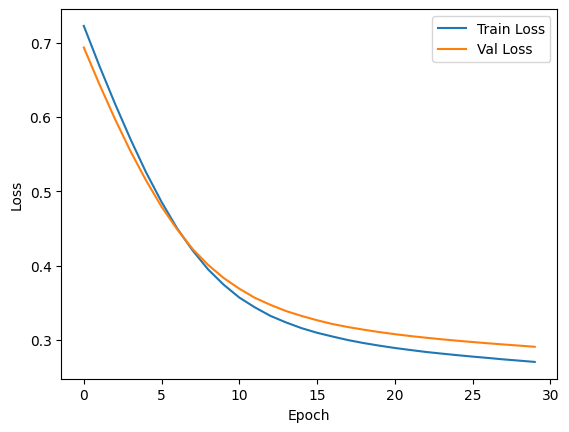

In [9]:
# ------------------------------------------------------------
# Full Colab-Ready PyTorch Training Script
# ------------------------------------------------------------
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# 1. Generate synthetic binary dataset
X, y = make_moons(n_samples=2000, noise=0.2, random_state=42)
scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_val   = torch.tensor(X_val, dtype=torch.float32)
y_val   = torch.tensor(y_val, dtype=torch.float32)

train_ds = torch.utils.data.TensorDataset(X_train, y_train)
val_ds   = torch.utils.data.TensorDataset(X_val, y_val)

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader   = torch.utils.data.DataLoader(val_ds, batch_size=64)

# 2. Define a simple model
class SimpleMLP(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 1)  # binary classification → single logit
        )
    def forward(self, x):
        return self.net(x)

model = SimpleMLP(X_train.shape[1])

# 3. Loss and optimizer
criterion = nn.BCEWithLogitsLoss()   # expects raw logits
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# 4. Training loop
E = 30
train_losses, val_losses = [], []

for epoch in range(E):
    model.train()
    total_loss = 0
    for x, y in train_loader:
        optimizer.zero_grad()
        logits = model(x).squeeze(1)
        loss = criterion(logits, y)
        loss.backward()
        # Optional gradient clipping:
        # nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        total_loss += loss.item()
    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x_val, y_val in val_loader:
            logits = model(x_val).squeeze(1)
            loss = criterion(logits, y_val)
            val_loss += loss.item()
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1:02d}: Train Loss={avg_train_loss:.4f}, Val Loss={avg_val_loss:.4f}")

# 5. Plot curves
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.4736 - loss: 1.0384 - val_accuracy: 0.7067 - val_loss: 0.7223 - learning_rate: 0.0010
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7637 - loss: 0.6539 - val_accuracy: 0.7767 - val_loss: 0.5388 - learning_rate: 0.0010
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8061 - loss: 0.5022 - val_accuracy: 0.7983 - val_loss: 0.4631 - learning_rate: 0.0010
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8419 - loss: 0.4178 - val_accuracy: 0.8133 - val_loss: 0.4232 - learning_rate: 0.0010
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8508 - loss: 0.3761 - val_accuracy: 0.8250 - val_loss: 0.3944 - learning_rate: 0.0010
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8695 - loss: 0.3509 - val_accuracy: 0.8417 - val_loss: 0.3700 - learning_rate: 0.0010
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8836 - loss: 0.3150 - val_accuracy:

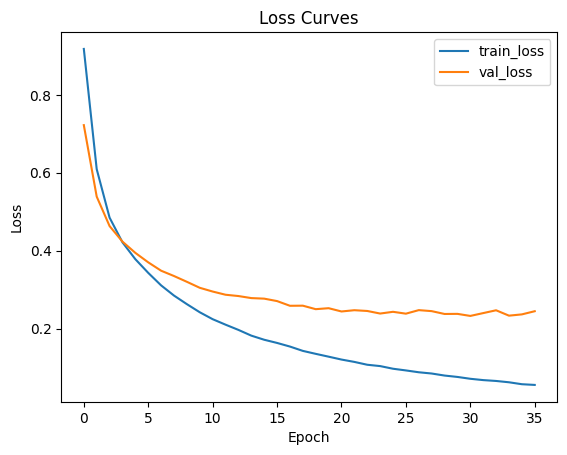

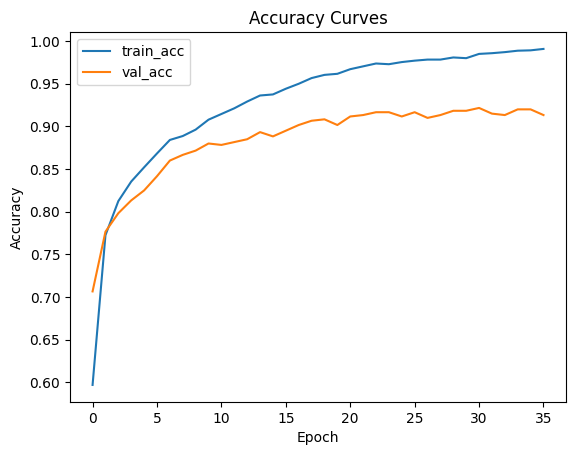

Validation accuracy (argmax on logits): 0.9217
Confusion matrix:
 [[175  10  15]
 [ 10 189   0]
 [ 12   0 189]]


In [10]:
# ================================
# Colab-Ready Keras Training Script
# Multi-class classification demo
# ================================
!pip -q install scikit-learn matplotlib

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# -------------------------------
# 1) Data: synthetic multi-class
# -------------------------------
num_classes = 3
X, y = make_classification(
    n_samples=3000,
    n_features=20,
    n_informative=10,
    n_redundant=2,
    n_classes=num_classes,
    class_sep=1.5,
    random_state=42,
)

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# One-hot labels for CategoricalCrossentropy
y_train_oh = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)
y_val_oh   = tf.keras.utils.to_categorical(y_val,   num_classes=num_classes)

batch_size = 64

train_ds = tf.data.Dataset.from_tensor_slices((X_train.astype(np.float32), y_train_oh.astype(np.float32))) \
                          .shuffle(2048).batch(batch_size)
val_ds   = tf.data.Dataset.from_tensor_slices((X_val.astype(np.float32),   y_val_oh.astype(np.float32))) \
                          .batch(batch_size)

# -------------------------------
# 2) Model: simple MLP with logits
# -------------------------------
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(num_classes)  # logits (no softmax here)
])

# ----------------------------------------
# 3) Compile with from_logits=True (stable)
# ----------------------------------------
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

# ----------------------------------------
# 4) Callbacks: EarlyStopping + ReduceLROnPlateau
# ----------------------------------------
es = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True
)
rlrop = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=3, verbose=1
)

# -------------------------------
# 5) Train
# -------------------------------
history = model.fit(
    train_ds,
    epochs=50,
    validation_data=val_ds,
    callbacks=[es, rlrop],
    verbose=1,
)

# -------------------------------
# 6) Plots: loss & accuracy
# -------------------------------
plt.figure()
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curves")
plt.show()

plt.figure()
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy Curves")
plt.show()

# -------------------------------
# 7) Quick evaluation
# -------------------------------
val_logits = model.predict(val_ds, verbose=0)
val_pred = np.argmax(val_logits, axis=1)
val_true = y_val

acc = (val_pred == val_true).mean()
print(f"Validation accuracy (argmax on logits): {acc:.4f}")

# Optional: confusion matrix
try:
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(val_true, val_pred)
    print("Confusion matrix:\n", cm)
except Exception as e:
    print("Confusion matrix skipped:", e)


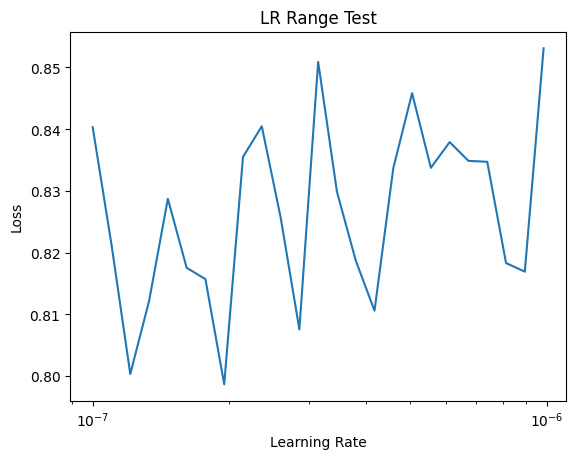

In [11]:
# ------------------------------------------------------------
# Full Colab-Ready PyTorch LR Range Test Script
# ------------------------------------------------------------
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# 1. Generate binary dataset
X, y = make_moons(n_samples=2000, noise=0.2, random_state=42)
scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)

train_ds = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=64, shuffle=True)

# 2. Define simple model
class SimpleMLP(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )
    def forward(self, x):
        return self.net(x)

model = SimpleMLP(X_train.shape[1])

# 3. Loss and optimizer (we will adjust lr dynamically)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-7)

# 4. LR Range Test loop
lrs, losses = [], []
lr = 1e-7

for step, (xb, yb) in enumerate(train_loader):
    # set LR dynamically
    for g in optimizer.param_groups:
        g["lr"] = lr

    optimizer.zero_grad()
    logits = model(xb).squeeze(1)
    loss = criterion(logits, yb)
    loss.backward()
    optimizer.step()

    lrs.append(lr)
    losses.append(loss.item())

    lr *= 1.1  # increase LR exponentially per step

    if lr > 10:  # stop when LR becomes too large
        break

# 5. Plot losses vs lrs (log-x)
plt.semilogx(lrs, losses)
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.title("LR Range Test")
plt.show()